## Data Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [3]:
# Load the CIFAR-10 dataset and divide it into training and testing sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Check the shape of the datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


In [4]:
# Define class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#const
num_classes = 10
input_shape = (32, 32, 3)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



# Check the shape of the datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")



Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 10)


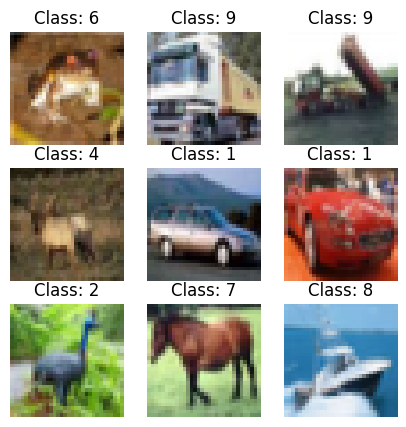

In [27]:
# Display a few random images from the training set
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {y_train[i].argmax()}")
    plt.axis('off')
plt.show()

## Create the Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Fully Connected Block
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


C:\Users\jaime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,442,090 (5.50 MB)

 Trainable params: 1,439,658 (5.49 MB)

 Non-trainable params: 2,432 (9.50 KB)

## Model Training

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=60,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]   
)


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.9531 - loss: 0.1392 - val_accuracy: 0.8607 - val_loss: 0.5254
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accuracy: 0.9612 - loss: 0.1140 - val_accuracy: 0.8603 - val_loss: 0.5685
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accuracy: 0.9631 - loss: 0.1088 - val_accuracy: 0.8543 - val_loss: 0.5730
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 1792s 2s/step - accuracy: 0.9619 - loss: 0.1089 - val_accuracy: 0.8590 - val_loss: 0.5834
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.9636 - loss: 0.1084 - val_accuracy: 0.8510 - val_loss: 0.6424
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.9651 - loss: 0.1034 - val_accuracy: 0.8539 - val_loss: 0.6097
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.9627 - loss: 0.1040 - val_accuracy: 0.8522 - val_loss: 0.6243
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accuracy: 0.9673 - loss

## Model Eval

Test Loss: 0.6455296874046326
Test Accuracy: 0.8508999943733215
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


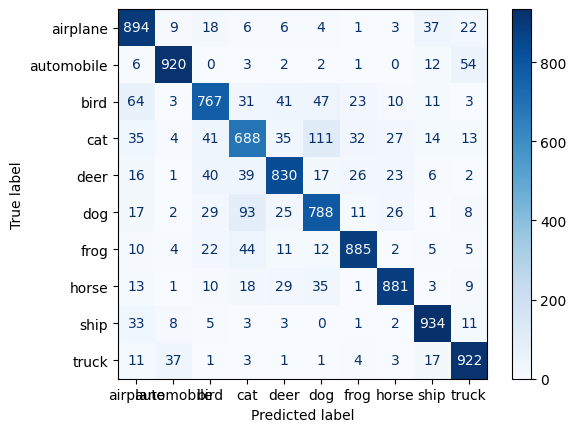

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

#Display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()



## Save the Model


In [53]:
# Save the model in TensorFlow SavedModel format

model.export('saved_model/my_model/1/')


INFO:tensorflow:Assets written to: saved_model/my_model/1/assets


INFO:tensorflow:Assets written to: saved_model/my_model/1/assets


Saved artifact at 'saved_model/my_model/1/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_1308')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1664798814096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798815440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798815824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798816016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798814672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798816400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798817360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798817744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798815248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664751649232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1664798817168: TensorSp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Predicted Class: automobile


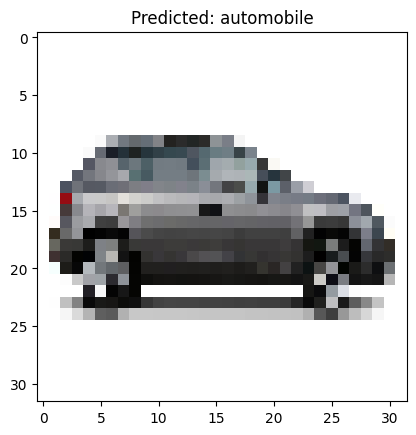

In [55]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load and preprocess the image
def preprocess_image(img_path, target_size=(32, 32)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Path to the image you want to predict
img_path = 'image-prediction/images/360_F_177742846_umwpEr5OqwEQd4a9VyS7BGJX3tINNDe7.jpg'  # Replace with the path to your image

# Preprocess the image
img_array = preprocess_image(img_path)

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Print the predicted class
print(f"Predicted Class: {class_names[predicted_class]}")

# Visualize the image
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.show()


## Transfer Learning

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom classification layers
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjust for CIFAR-10's 10 classes
])

# Compile the model
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model (assuming `train_dataset` and `test_dataset` are properly set up)
history = transfer_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]   
)

# Evaluate the model on the test dataset
test_loss, test_acc = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

y_pred = transfer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()





Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 270s 171ms/step - accuracy: 0.3855 - loss: 1.7446 - val_accuracy: 0.5411 - val_loss: 1.3114
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 267s 171ms/step - accuracy: 0.5246 - loss: 1.3651 - val_accuracy: 0.5620 - val_loss: 1.2518
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 248s 159ms/step - accuracy: 0.5474 - loss: 1.2951 - val_accuracy: 0.5756 - val_loss: 1.2113
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 243s 156ms/step - accuracy: 0.5590 - loss: 1.2638 - val_accuracy: 0.5863 - val_loss: 1.1974
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 253s 162ms/step - accuracy: 0.5655 - loss: 1.2412 - val_accuracy: 0.5896 - val_loss: 1.1739
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 312s 200ms/step - accuracy: 0.5739 - loss: 1.2240 - val_accuracy: 0.5932 - val_loss: 1.1619
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 269s 172ms/step - accuracy: 0.5777 - loss: 1.2069 - val_accuracy: 0.5968 - val_loss: 1.1606
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 254s 162ms/step - ac

NameError: name 'ConfusionMatrixDisplay' is not defined

In [34]:
import os
print(os.listdir("saved_model/my_model"))

['assets', 'fingerprint.pb', 'saved_model.pb', 'variables']
